In [1]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


C:\Users\melvi\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3

filtered_data=pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 10000""", con) 



# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(9564, 10)

In [3]:
nltk.download("stopwords")
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\melvi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [5]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [6]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [7]:
# Sorting data based on time
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final= final.sort_values(by = "Time")
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,2000-06-23,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...
7427,8111,B0000EIE2Z,A3M174IC0VXOS2,Gail Cooke,3,3,positive,2004-01-30,BEST BLUEBERRIES,In the winter when fresh blueberries exceed ou...,winter fresh blueberri exceed food budget dri ...
3481,3783,B00016UX0K,AF1PV3DIC0XM7,Robert Ashton,1,2,positive,2004-04-10,Classic Condiment,Mae Ploy Sweet Chili Sauce is becoming a stand...,mae ploy sweet chili sauc becom standard condi...
6790,7432,B0001E1IME,A2IKCTD1I73PLW,Adeba,2,8,positive,2004-05-02,amazon monopoly/ripoff,love the snack. wanted to buy a bunch.<p>ship...,love snack want buy bunch ship amazon price sn...


In [8]:
from sklearn.model_selection import train_test_split
X = final["CleanedText"]
y = final["Score"]
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle='false')
print(X_train.shape, y_train.shape, x_test.shape)

(6694,) (6694,) (2870,)


In [10]:
bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_train

<6694x10189 sparse matrix of type '<class 'numpy.int64'>'
	with 203537 stored elements in Compressed Sparse Row format>

In [11]:
x_test = bow.transform(x_test)
x_test.shape
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)


In [12]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier(algorithm='brute')
# neigh = np.arange(1,100,2)
param_grid = {'n_neighbors':np.arange(1,50,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=4) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best HyperParameter:  {'n_neighbors': 11}
Best Accuracy: 83.18%


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished


# OBSERVATION
Optimal k for bow is 11.


The accuracy of the knn classifier for k = 11 is 83.728223%


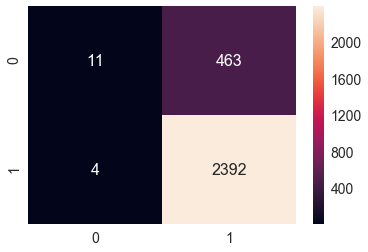

In [15]:
from sklearn.metrics import accuracy_score
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=11,algorithm='brute')

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100

print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (11, acc))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [16]:
train_acc_bow = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_bow)

Train accuracy 0.8426949507021213


# OBSERVATION
11 knn using 10 fold cross validation produces 83.73% accuracy on predicting unseen review as positive or negative.(Brute force) using bow.

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished


Best HyperParameter:  {'n_neighbors': 11}
Best Accuracy: 83.18%

The accuracy of the knn classifier for k = 11 is 83.728223%


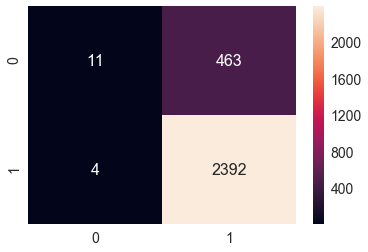

In [13]:
from sklearn.metrics import accuracy_score
# instantiate learning model k = optimal_k
knn = KNeighborsClassifier(algorithm='kd_tree')
# neigh = np.arange(1,100,2)
param_grid = {'n_neighbors':np.arange(1,50,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=4) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=5, random_state=42)
svd.fit(X_train)
knn_optimal = KNeighborsClassifier(n_neighbors=11,algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (11, acc))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# OBSERVATION
11 knn using 10 fold cross validation produces 83.73% accuracy on predicting unseen review as positive or negative.(KD tree method) using bow.

In [27]:
X = final["CleanedText"]
y = final["Score"]
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42,shuffle='false')
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(6694,) (2870,) (6694,) (2870,)


In [15]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vect.fit_transform(X_train)

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [29]:
x_test = tf_idf_vect.transform(x_test)


In [23]:
knn = KNeighborsClassifier(algorithm='brute')
# neigh = np.arange(1,100,2)
param_grid = {'n_neighbors':np.arange(1,50,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=4) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best HyperParameter:  {'n_neighbors': 5}
Best Accuracy: 84.14%


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished


# OBSERVATION
Optimal k for tfidf is 5.


The accuracy of the knn classifier for k = 5 is 83.170732%


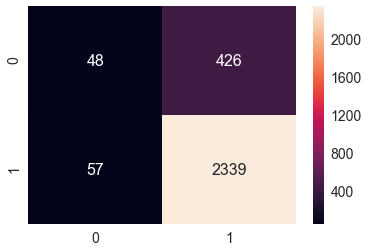

In [17]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=5,algorithm='brute')

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)
    
# predict the response
pred = knn_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (5, acc))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [18]:
train_acc_bow = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_bow)

Train accuracy 0.8659994024499552


# OBSERVATION
11 knn using 10 fold cross validation produces 85.74% accuracy on predicting unseen review as positive or negative.(brute force method) using tfidf.

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished


Best HyperParameter:  {'n_neighbors': 11}
Best Accuracy: 83.18%

The accuracy of the knn classifier for k = 5 is 83.170732%


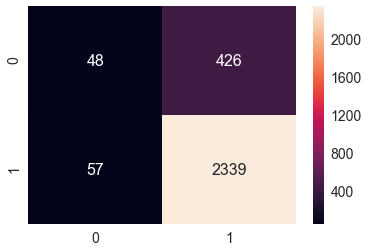

In [14]:
knn = KNeighborsClassifier(algorithm='kd_tree')
# neigh = np.arange(1,100,2)
param_grid = {'n_neighbors':np.arange(1,50,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=4) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=5, random_state=42)
svd.fit(X_train)
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=5,algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)
    
# predict the response
pred = knn_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (5, acc))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# OBSERVATION
11 knn using 10 fold cross validation produces 85.74% accuracy on predicting unseen review as positive or negative.(KD tree method) using tfidf.

In [9]:
from sklearn.model_selection import train_test_split
X = final["Text"]
y = final["Score"]
X_train, x_test, y_train, y_test =train_test_split(X, y.values, test_size = 0.3, shuffle='false')
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)


(6694,) (2870,) (6694,) (2870,)


In [10]:
list_of_sent=[]
#for sent in final_40k['Text'].values:
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
import gensim
list_of_sent_test = []
#for sent in final_40k['Text'].values:
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)    

In [11]:
import gensim
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [12]:
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

6694
50
2870
50


In [13]:
X_train = sent_vectors
x_test = sent_vectors_test

In [88]:
knn = KNeighborsClassifier(algorithm='brute')
# neigh = np.arange(1,100,2)
param_grid = {'n_neighbors':np.arange(1,50,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=4) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best HyperParameter:  {'n_neighbors': 21}
Best Accuracy: 83.65%


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   37.3s finished


# OBSERVATION
Optimal k for avg w2vec is 21.


The accuracy of the knn classifier for k = 21 is 84.285714%


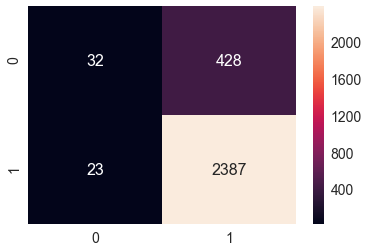

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=21, algorithm='brute')

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)
    
# predict the response
pred = knn_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (21, acc))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [25]:
train_acc_bow = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_bow)

Train accuracy 0.8361219002091426


# OBSERVATION
11 knn using 10 fold cross validation produces 83.38% accuracy on predicting unseen review as positive or negative.(brute force method) using avg w2vec.

In [45]:
knn = KNeighborsClassifier(algorithm='kd_tree')
# neigh = np.arange(1,100,2)
param_grid = {'n_neighbors':np.arange(1,50,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=4) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1,n_jobs=-1)
gsv.fit(X_train,y_train)
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=5, random_state=42)
svd.fit(X_train)
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=21, algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)
    
# predict the response
pred = knn_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (21, acc))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Fitting 4 folds for each of 25 candidates, totalling 100 fits


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\melvi\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\melvi\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x0000015CB2E14ED0, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\melvi\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\melvi\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\m...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x0000015CB2E14ED0, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\melvi\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\melvi\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\m...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\tornado\platform\asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    122         except (RuntimeError, AssertionError):
    123             old_loop = None
    124         try:
    125             self._setup_logging()
    126             asyncio.set_event_loop(self.asyncio_loop)
--> 127             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Win...EventLoop running=True closed=False debug=False>>
    128         finally:
    129             asyncio.set_event_loop(old_loop)
    130 
    131     def stop(self):

...........................................................................
C:\Users\melvi\Anaconda3\lib\asyncio\base_events.py in run_forever(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_Windo...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
C:\Users\melvi\Anaconda3\lib\asyncio\base_events.py in _run_once(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
   1427                         logger.warning('Executing %s took %.3f seconds',
   1428                                        _format_handle(handle), dt)
   1429                 finally:
   1430                     self._current_handle = None
   1431             else:
-> 1432                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(556, 1)>>
   1433         handle = None  # Needed to break cycles when an exception occurs.
   1434 
   1435     def _set_coroutine_wrapper(self, enabled):
   1436         try:

...........................................................................
C:\Users\melvi\Anaconda3\lib\asyncio\events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(556, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (556, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\tornado\platform\asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=556, events=1)
    112             self.writers.remove(fd)
    113         del self.handlers[fd]
    114 
    115     def _handle_events(self, fd, events):
    116         fileobj, handler_func = self.handlers[fd]
--> 117         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    118 
    119     def start(self):
    120         try:
    121             old_loop = asyncio.get_event_loop()

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'knn = KNeighborsClassifier(algorithm=\'kd_tree\')\n...f_cm, annot=True,annot_kws={"size": 16}, fmt=\'g\')', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 10, 6, 11, 25, 50, 363778, tzinfo=tzutc()), 'msg_id': '8e4183be54ed4723881da45929160c11', 'msg_type': 'execute_request', 'session': 'c065aa177eac49ed99bb924e9a534e07', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '8e4183be54ed4723881da45929160c11', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'c065aa177eac49ed99bb924e9a534e07']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'knn = KNeighborsClassifier(algorithm=\'kd_tree\')\n...f_cm, annot=True,annot_kws={"size": 16}, fmt=\'g\')', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 10, 6, 11, 25, 50, 363778, tzinfo=tzutc()), 'msg_id': '8e4183be54ed4723881da45929160c11', 'msg_type': 'execute_request', 'session': 'c065aa177eac49ed99bb924e9a534e07', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '8e4183be54ed4723881da45929160c11', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'c065aa177eac49ed99bb924e9a534e07'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'knn = KNeighborsClassifier(algorithm=\'kd_tree\')\n...f_cm, annot=True,annot_kws={"size": 16}, fmt=\'g\')', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 10, 6, 11, 25, 50, 363778, tzinfo=tzutc()), 'msg_id': '8e4183be54ed4723881da45929160c11', 'msg_type': 'execute_request', 'session': 'c065aa177eac49ed99bb924e9a534e07', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '8e4183be54ed4723881da45929160c11', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='knn = KNeighborsClassifier(algorithm=\'kd_tree\')\n...f_cm, annot=True,annot_kws={"size": 16}, fmt=\'g\')', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'knn = KNeighborsClassifier(algorithm=\'kd_tree\')\n...f_cm, annot=True,annot_kws={"size": 16}, fmt=\'g\')'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('knn = KNeighborsClassifier(algorithm=\'kd_tree\')\n...f_cm, annot=True,annot_kws={"size": 16}, fmt=\'g\')',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('knn = KNeighborsClassifier(algorithm=\'kd_tree\')\n...f_cm, annot=True,annot_kws={"size": 16}, fmt=\'g\')',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='knn = KNeighborsClassifier(algorithm=\'kd_tree\')\n...f_cm, annot=True,annot_kws={"size": 16}, fmt=\'g\')', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = 'knn = KNeighborsClassifier(algorithm=\'kd_tree\')\n...f_cm, annot=True,annot_kws={"size": 16}, fmt=\'g\')'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='knn = KNeighborsClassifier(algorithm=\'kd_tree\')\n...f_cm, annot=True,annot_kws={"size": 16}, fmt=\'g\')', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-45-7a35ef218aa6>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 15cbf73ee80, executio...rue silent=False shell_futures=True> result=None>)
   2898 
   2899         try:
   2900             for i, node in enumerate(to_run_exec):
   2901                 mod = ast.Module([node])
   2902                 code = compiler(mod, cell_name, "exec")
-> 2903                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x0000015CBFBAAA50, file "<ipython-input-45-7a35ef218aa6>", line 6>
        result = <ExecutionResult object at 15cbf73ee80, executio...rue silent=False shell_futures=True> result=None>
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x0000015CBFBAAA50, file "<ipython-input-45-7a35ef218aa6>", line 6>, result=<ExecutionResult object at 15cbf73ee80, executio...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x0000015CBFBAAA50, file "<ipython-input-45-7a35ef218aa6>", line 6>
        self.user_global_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import warnings\nwarnings.filterwarnings("ignore"...m gensim.models import KeyedVectors\nimport pickle', 'import warnings\nwarnings.filterwarnings("ignore"...m gensim.models import KeyedVectors\nimport pickle', '# using the SQLite Table to read data.\ncon = sql..."Text"}, keep=\'first\', inplace=False)\nfinal.shape', 'nltk.download("stopwords")\nstop = set(stopwords....\'[.|,|)|(|\\|/]\',r\' \',cleaned)\n    return  cleaned', 'i=0\nstr1=\' \'\nfinal_string=[]\nall_positive_words=...***")\n    \n    final_string.append(str1)\n    i+=1', 'final[\'CleanedText\']=final_string #adding a colu...edText\']=final[\'CleanedText\'].str.decode("utf-8")', "conn = sqlite3.connect('final.sqlite')\nc=conn.cu...ue, index_label=None, chunksize=None, dtype=None)", '# Sorting data based on time\nfinal["Time"] = pd....nal= final.sort_values(by = "Time")\nfinal.head(5)', 'from sklearn.model_selection import train_test_s...print(X_train.shape, y_train.shape, x_test.shape)', 'bow = CountVectorizer()\nX_train = bow.fit_transform(X_train)\nX_train', 'x_test = bow.transform(x_test)\nx_test.shape\nfrom...meSeriesSplit\ntscv = TimeSeriesSplit(n_splits=10)', 'from sklearn.model_selection import TimeSeriesSp...nt("Best Accuracy: %.2f%%"%(gsv.best_score_*100))', 'from sklearn.metrics import accuracy_score\n# ins...f_cm, annot=True,annot_kws={"size": 16}, fmt=\'g\')', 'knn = KNeighborsClassifier(algorithm=\'kd_tree\')\n...f_cm, annot=True,annot_kws={"size": 16}, fmt=\'g\')', 'from sklearn.model_selection import train_test_s...shape, x_test.shape, y_train.shape, y_test.shape)', "list_of_sent=[]\n#for sent in final_40k['Text'].v...  list_of_sent_test.append(filtered_sentence)    ", "list_of_sent=[]\n#for sent in final_40k['Text'].v...  list_of_sent_test.append(filtered_sentence)    ", 'import gensim\nw2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)', '# compute average word2vec for each review.\nsent...t_vectors_test))\nprint(len(sent_vectors_test[0]))', ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'KeyedVectors': <class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>, 'Out': {3: (9564, 10), 8:         Id   ProductId          UserId    Profil...ve snack want buy bunch ship amazon price sn...  , 10: <6694x10189 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, 13: <matplotlib.axes._subplots.AxesSubplot object>, 14: <matplotlib.axes._subplots.AxesSubplot object>, 21: <matplotlib.axes._subplots.AxesSubplot object>, 22: <matplotlib.axes._subplots.AxesSubplot object>}, 'PorterStemmer': <class 'nltk.stem.porter.PorterStemmer'>, 'TfidfTransformer': <class 'sklearn.feature_extraction.text.TfidfTransformer'>, 'TfidfVectorizer': <class 'sklearn.feature_extraction.text.TfidfVectorizer'>, 'TimeSeriesSplit': <class 'sklearn.model_selection._split.TimeSeriesSplit'>, ...}
        self.user_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import warnings\nwarnings.filterwarnings("ignore"...m gensim.models import KeyedVectors\nimport pickle', 'import warnings\nwarnings.filterwarnings("ignore"...m gensim.models import KeyedVectors\nimport pickle', '# using the SQLite Table to read data.\ncon = sql..."Text"}, keep=\'first\', inplace=False)\nfinal.shape', 'nltk.download("stopwords")\nstop = set(stopwords....\'[.|,|)|(|\\|/]\',r\' \',cleaned)\n    return  cleaned', 'i=0\nstr1=\' \'\nfinal_string=[]\nall_positive_words=...***")\n    \n    final_string.append(str1)\n    i+=1', 'final[\'CleanedText\']=final_string #adding a colu...edText\']=final[\'CleanedText\'].str.decode("utf-8")', "conn = sqlite3.connect('final.sqlite')\nc=conn.cu...ue, index_label=None, chunksize=None, dtype=None)", '# Sorting data based on time\nfinal["Time"] = pd....nal= final.sort_values(by = "Time")\nfinal.head(5)', 'from sklearn.model_selection import train_test_s...print(X_train.shape, y_train.shape, x_test.shape)', 'bow = CountVectorizer()\nX_train = bow.fit_transform(X_train)\nX_train', 'x_test = bow.transform(x_test)\nx_test.shape\nfrom...meSeriesSplit\ntscv = TimeSeriesSplit(n_splits=10)', 'from sklearn.model_selection import TimeSeriesSp...nt("Best Accuracy: %.2f%%"%(gsv.best_score_*100))', 'from sklearn.metrics import accuracy_score\n# ins...f_cm, annot=True,annot_kws={"size": 16}, fmt=\'g\')', 'knn = KNeighborsClassifier(algorithm=\'kd_tree\')\n...f_cm, annot=True,annot_kws={"size": 16}, fmt=\'g\')', 'from sklearn.model_selection import train_test_s...shape, x_test.shape, y_train.shape, y_test.shape)', "list_of_sent=[]\n#for sent in final_40k['Text'].v...  list_of_sent_test.append(filtered_sentence)    ", "list_of_sent=[]\n#for sent in final_40k['Text'].v...  list_of_sent_test.append(filtered_sentence)    ", 'import gensim\nw2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)', '# compute average word2vec for each review.\nsent...t_vectors_test))\nprint(len(sent_vectors_test[0]))', ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'KeyedVectors': <class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>, 'Out': {3: (9564, 10), 8:         Id   ProductId          UserId    Profil...ve snack want buy bunch ship amazon price sn...  , 10: <6694x10189 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, 13: <matplotlib.axes._subplots.AxesSubplot object>, 14: <matplotlib.axes._subplots.AxesSubplot object>, 21: <matplotlib.axes._subplots.AxesSubplot object>, 22: <matplotlib.axes._subplots.AxesSubplot object>}, 'PorterStemmer': <class 'nltk.stem.porter.PorterStemmer'>, 'TfidfTransformer': <class 'sklearn.feature_extraction.text.TfidfTransformer'>, 'TfidfVectorizer': <class 'sklearn.feature_extraction.text.TfidfVectorizer'>, 'TimeSeriesSplit': <class 'sklearn.model_selection._split.TimeSeriesSplit'>, ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
C:\Users\melvi\Untitled Folder\<ipython-input-45-7a35ef218aa6> in <module>()
      1 knn = KNeighborsClassifier(algorithm='kd_tree')
      2 # neigh = np.arange(1,100,2)
      3 param_grid = {'n_neighbors':np.arange(1,50,2)} #params we need to try on classifier
      4 tscv = TimeSeriesSplit(n_splits=4) #For time based splitting
      5 gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1,n_jobs=-1)
----> 6 gsv.fit(X_train,y_train)
      7 from sklearn.decomposition import TruncatedSVD
      8 svd = TruncatedSVD(n_components=5, random_state=42)
      9 svd.fit(X_train)
     10 # instantiate learning model k = optimal_k

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py in fit(self=GridSearchCV(cv=TimeSeriesSplit(max_train_size=N...ain_score='warn',
       scoring=None, verbose=1), X=6531    These were just what I was looking for, ... found...
Name: Text, Length: 6694, dtype: object, y=array(['positive', 'positive', 'positive', ..., ...e', 'positive',
       'positive'], dtype=object), groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method TimeSeriesSplit.split of TimeSeriesSplit(max_train_size=None, n_splits=4)>
        X = 6531    These were just what I was looking for, ... found...
Name: Text, Length: 6694, dtype: object
        y = array(['positive', 'positive', 'positive', ..., ...e', 'positive',
       'positive'], dtype=object)
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sat Oct  6 16:55:51 2018
PID: 6560                 Python 3.6.5: C:\Users\melvi\Anaconda3\python.exe
...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (KNeighborsClassifier(algorithm='kd_tree', leaf_s...n_neighbors=1, p=2,
           weights='uniform'), 6531    These were just what I was looking for, ... found...
Name: Text, Length: 6694, dtype: object, array(['positive', 'positive', 'positive', ..., ...e', 'positive',
       'positive'], dtype=object), {'score': <function _passthrough_scorer>}, array([   0,    1,    2, ..., 1339, 1340, 1341]), array([1342, 1343, 1344, ..., 2677, 2678, 2679]), 1, {'n_neighbors': 1}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (KNeighborsClassifier(algorithm='kd_tree', leaf_s...n_neighbors=1, p=2,
           weights='uniform'), 6531    These were just what I was looking for, ... found...
Name: Text, Length: 6694, dtype: object, array(['positive', 'positive', 'positive', ..., ...e', 'positive',
       'positive'], dtype=object), {'score': <function _passthrough_scorer>}, array([   0,    1,    2, ..., 1339, 1340, 1341]), array([1342, 1343, 1344, ..., 2677, 2678, 2679]), 1, {'n_neighbors': 1})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_s...n_neighbors=1, p=2,
           weights='uniform'), X=6531    These were just what I was looking for, ... found...
Name: Text, Length: 6694, dtype: object, y=array(['positive', 'positive', 'positive', ..., ...e', 'positive',
       'positive'], dtype=object), scorer={'score': <function _passthrough_scorer>}, train=array([   0,    1,    2, ..., 1339, 1340, 1341]), test=array([1342, 1343, 1344, ..., 2677, 2678, 2679]), verbose=1, parameters={'n_neighbors': 1}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method SupervisedIntegerMixin.fit of KNei..._neighbors=1, p=2,
           weights='uniform')>
        X_train = 6531    These were just what I was looking for, ...s!  Bo...
Name: Text, Length: 1342, dtype: object
        y_train = array(['positive', 'positive', 'positive', ..., ...e', 'negative',
       'positive'], dtype=object)
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\sklearn\neighbors\base.py in fit(self=KNeighborsClassifier(algorithm='kd_tree', leaf_s...n_neighbors=1, p=2,
           weights='uniform'), X=6531    These were just what I was looking for, ...s!  Bo...
Name: Text, Length: 1342, dtype: object, y=array(['positive', 'positive', 'positive', ..., ...e', 'negative',
       'positive'], dtype=object))
    760         y : {array-like, sparse matrix}
    761             Target values of shape = [n_samples] or [n_samples, n_outputs]
    762 
    763         """
    764         if not isinstance(X, (KDTree, BallTree)):
--> 765             X, y = check_X_y(X, y, "csr", multi_output=True)
        X = 6531    These were just what I was looking for, ...s!  Bo...
Name: Text, Length: 1342, dtype: object
        y = array(['positive', 'positive', 'positive', ..., ...e', 'negative',
       'positive'], dtype=object)
    766 
    767         if y.ndim == 1 or y.ndim == 2 and y.shape[1] == 1:
    768             if y.ndim != 1:
    769                 warnings.warn("A column-vector y was passed when a 1d array "

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\sklearn\utils\validation.py in check_X_y(X=6531    These were just what I was looking for, ...s!  Bo...
Name: Text, Length: 1342, dtype: object, y=array(['positive', 'positive', 'positive', ..., ...e', 'negative',
       'positive'], dtype=object), accept_sparse='csr', dtype='numeric', order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, multi_output=True, ensure_min_samples=1, ensure_min_features=1, y_numeric=False, warn_on_dtype=False, estimator=None)
    568     y_converted : object
    569         The converted and validated y.
    570     """
    571     X = check_array(X, accept_sparse, dtype, order, copy, force_all_finite,
    572                     ensure_2d, allow_nd, ensure_min_samples,
--> 573                     ensure_min_features, warn_on_dtype, estimator)
        ensure_min_features = 1
        warn_on_dtype = False
        estimator = None
    574     if multi_output:
    575         y = check_array(y, 'csr', force_all_finite=True, ensure_2d=False,
    576                         dtype=None)
    577     else:

...........................................................................
C:\Users\melvi\Anaconda3\lib\site-packages\sklearn\utils\validation.py in check_array(array=6531    These were just what I was looking for, ...s!  Bo...
Name: Text, Length: 1342, dtype: object, accept_sparse='csr', dtype=<class 'numpy.float64'>, order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, ensure_min_samples=1, ensure_min_features=1, warn_on_dtype=False, estimator=None)
    428 
    429     if sp.issparse(array):
    430         array = _ensure_sparse_format(array, accept_sparse, dtype, copy,
    431                                       force_all_finite)
    432     else:
--> 433         array = np.array(array, dtype=dtype, order=order, copy=copy)
        array = 6531    These were just what I was looking for, ...s!  Bo...
Name: Text, Length: 1342, dtype: object
        dtype = <class 'numpy.float64'>
        order = None
        copy = False
    434 
    435         if ensure_2d:
    436             if array.ndim == 1:
    437                 raise ValueError(

ValueError: could not convert string to float: 'These 100 calorie Cakesters are delicious!  Both the vanilla<br />and the chocolate are great, they satisfy those little "sweet"<br />cravings and its only 100 calories for three little cakes!'
___________________________________________________________________________

# OBSERVATION
11 knn using 10 fold cross validation produces 83.38% accuracy on predicting unseen review as positive or negative.(KD tree method) using avg w2vec.

In [14]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1  

NameError: name 'tf_idf_vect' is not defined

In [93]:
X_train = tfidf_sent_vectors

In [94]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1  

In [95]:
x_test = tfidf_sent_vectors_test
X_train = np.nan_to_num(X_train)
x_test = np.nan_to_num(x_test)

In [96]:
knn = KNeighborsClassifier(algorithm='brute')
# neigh = np.arange(1,100,2)
param_grid = {'n_neighbors':np.arange(1,50,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=4) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best HyperParameter:  {'n_neighbors': 1}
Best Accuracy: 83.63%


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   35.0s finished


# OBSERVATION
Optimal k for tfidf w2vec is 1.


The accuracy of the knn classifier for k = 1 is 73.170732%


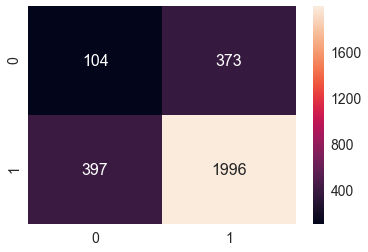

In [26]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=1,algorithm='brute')

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)
    
# predict the response
pred = knn_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (1, acc))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# OBSERVATION
11 knn using 10 fold cross validation produces 73.17% accuracy on predicting unseen review as positive or negative.(brute force method) using tfidf w2vec.

In [45]:
train_acc_bow = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_bow)

Train accuracy 1.0


Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.6min finished



The accuracy of the knn classifier for k = 1 is 74.285714%


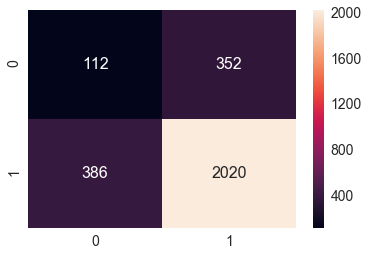

In [44]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier(algorithm='kd_tree')
# neigh = np.arange(1,100,2)
param_grid = {'n_neighbors':np.arange(1,50,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=4) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=5, random_state=42)
svd.fit(X_train)
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=1,algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)
    
# predict the response
pred = knn_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (1, acc))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### OBSERVATION
1.11 knn using 10 fold cross validation produces 74.28% accuracy on predicting unseen review as positive or negative.(KD tree method) using tfidf w2vec.
2.KD tree gets better results as accuracy is higher.

# OBSERVATION
1.tfidf prooved to be the best technique out of the three as it had the highest accuracy on unseen data.

In [8]:
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')

from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "Hyper parameter", "Train error", "Test error"]
x.add_row(["BOW", 11, 15.74, 16.28])
x.add_row(["TFIDF", 5, 13.41, 14.26])
x.add_row(["AVGW2V", 21, 16.39, 16.83])
x.add_row(["TFIDFW2V", 1, 0, 16.52])
print(x)



+----------+-----------------+-------------+------------+
|  Model   | Hyper parameter | Train error | Test error |
+----------+-----------------+-------------+------------+
|   BOW    |        11       |    15.74    |   16.28    |
|  TFIDF   |        5        |    13.41    |   14.26    |
|  AVGW2V  |        21       |    16.39    |   16.83    |
| TFIDFW2V |        1        |      0      |   16.52    |
+----------+-----------------+-------------+------------+
